# Syed Muhammad Zain Computer Vision Deep Learning Model


## Importing libraries

In [1]:
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import *
from keras.utils import np_utils
from keras.optimizers import Adam
from tqdm import tqdm
import seaborn as sns
import numpy as np
import numpy as np
import pandas as pd
import os
from keras.layers import (Dropout, Input, Dense, Conv2D, 
                          MaxPooling2D, GlobalAveragePooling2D, 
                          UpSampling2D, Conv2DTranspose, 
                          Reshape, Flatten, Activation, 
                          BatchNormalization)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploratory Data Analysis

In [3]:
Train_data1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CV emnist project/EMNIST data set/emnist-balanced-train.csv', header=None)

In [4]:
Train_data1.shape

(112800, 785)

In [5]:
#splitting data into xtrain and ytrain
trainingy=Train_data1[[0]]
trainingx=Train_data1.drop([0],axis=1)
print(trainingy.shape)
print(trainingx.shape)

(112800, 1)
(112800, 784)


In [6]:
#converting to series
trainingy=Train_data1[0]
trainingy.shape

(112800,)

In [7]:
mapping=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CV emnist project/EMNIST data set/emnist-balanced-mapping.txt", 
                        delimiter = ' ', 
                        index_col=0, 
                        header=None, 
                        squeeze=True)
mapping.head()

0
0    48
1    49
2    50
3    51
4    52
Name: 1, dtype: int64

In [8]:
mappingdict = {}
for i,L in enumerate(mapping):
    mappingdict[i] = chr(L)

mappingdict

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

In [9]:
def correctingimage(imageforcorrection):
    imageforcorrection = imageforcorrection.reshape(28, 28)
    imageforcorrection = np.fliplr(imageforcorrection)
    imageforcorrection = np.rot90(imageforcorrection)
    return imageforcorrection

In [10]:
trainingx = np.apply_along_axis(correctingimage, 1, trainingx)
trainingx.shape

(112800, 28, 28)

In [11]:
#normalizing x and one hot encoding y both are not dataframes
def preprocess(x):    
    x = x.reshape(-1, 28, 28, 1) #-1 means number of examples are undefined/unknown
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

In [12]:
trainingx=preprocess(trainingx)

In [13]:
print(trainingx.max(),trainingx.min())

1.0 -1.0


In [14]:
gopt = Adam(0.0001, 0.5)
dopt = Adam(0.0002, 0.5)
ND = 100


## Training and testing

In [15]:
def Gena():

    convmodel = Sequential()

    convmodel.add(Dense(512, input_dim=ND))
    convmodel.add(BatchNormalization(momentum=0.8))
    convmodel.add(Activation("relu"))
    
    convmodel.add(Dense(490, input_dim=ND))
    convmodel.add(BatchNormalization(momentum=0.8))
    convmodel.add(Activation("relu"))
    
    convmodel.add(Reshape((7, 7, 10)))
    
    convmodel.add(UpSampling2D((2, 2)))
    convmodel.add(Conv2D(64, (2, 2), padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02)))
    convmodel.add(BatchNormalization(momentum=0.8))
    convmodel.add(LeakyReLU(0.2))
    convmodel.add(UpSampling2D((2, 2)))
   
    convmodel.add(Conv2D(1, (3, 3), padding='same', activation = "tanh", 
                     kernel_initializer=RandomNormal(0, 0.02)))
    
    return convmodel

In [16]:
def Disc():
    convmodel = Sequential()
    
    convmodel.add(Conv2D(64, (2, 2), strides=2, padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02), 
                     input_shape=(28, 28, 1)))
    convmodel.add(LeakyReLU(0.2))
    
    convmodel.add(Conv2D(128, (2, 2), strides=2, 
                     kernel_initializer=RandomNormal(0, 0.02)))
    convmodel.add(LeakyReLU(0.2))
    
    convmodel.add(Flatten())
    
    
    convmodel.add(Dense(64))
    convmodel.add(Dense(64))
    convmodel.add(LeakyReLU(0.2))
    
    convmodel.add(Dropout(0.5))
    convmodel.add(Dense(1, activation='sigmoid'))
    
    convmodel.compile(loss='binary_crossentropy', optimizer=dopt)
    return convmodel

In [17]:
G = Gena()
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 490)               251370    
_________________________________________________________________
batch_normalization_1 (Batch (None, 490)               1960      
_________________________________________________________________
activation_1 (Activation)    (None, 490)               0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 10)          0

In [18]:
D= Disc()
D.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         32896     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                401472    
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [19]:
noisegenerated = Input(shape=(ND,))
fake_data_generated = G(noisegenerated )
D.trainable = False
OUTPUT1 = D(fake_data_generated)
DCGAN=Model(noisegenerated , OUTPUT1)
DCGAN.compile(loss='binary_crossentropy', optimizer=gopt)
 





In [20]:
FN= np.random.normal(0, 1, size=(30, ND))


In [21]:
def show_results(title, epoch):
    imgs = G.predict(FN)
    imgs = 0.5 * imgs + 0.5
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((28,28)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 15)
    plt.savefig(str(epoch)+".png", transparent=True)
    plt.show()

In [22]:
epochs = 1000
batch_size = 128
steps_per_epoch = len(trainingx)//batch_size

current epouch is:  0
discriminator loss currently is :  0.612040638923645
generator loss currently is:  0.8100241422653198
--------------------------------------------------------------------------------


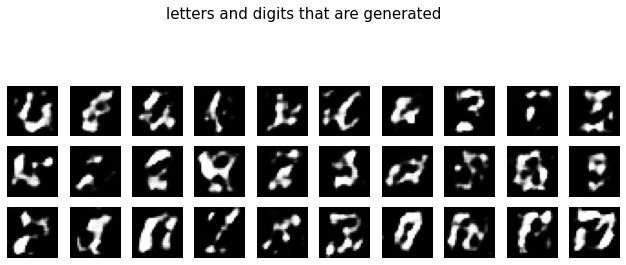

current epouch is:  1
discriminator loss currently is :  0.6072133779525757
generator loss currently is:  0.6312498450279236
--------------------------------------------------------------------------------
current epouch is:  2
discriminator loss currently is :  0.5573957562446594
generator loss currently is:  1.0950738191604614
--------------------------------------------------------------------------------
current epouch is:  3
discriminator loss currently is :  0.5279558300971985
generator loss currently is:  0.9309701919555664
--------------------------------------------------------------------------------
current epouch is:  4
discriminator loss currently is :  0.506177544593811
generator loss currently is:  1.0950865745544434
--------------------------------------------------------------------------------
current epouch is:  5
discriminator loss currently is :  0.5299058556556702
generator loss currently is:  1.0145951509475708
----------------------------------------------------

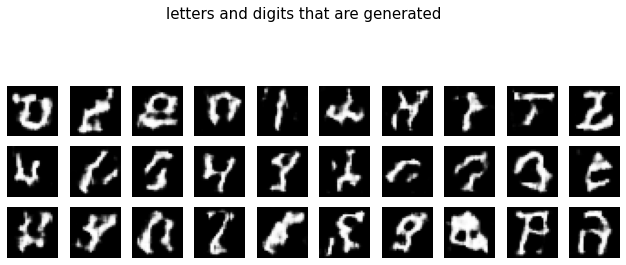

current epouch is:  6
discriminator loss currently is :  0.5055091381072998
generator loss currently is:  1.490822434425354
--------------------------------------------------------------------------------
current epouch is:  7
discriminator loss currently is :  0.4565751850605011
generator loss currently is:  1.3891782760620117
--------------------------------------------------------------------------------
current epouch is:  8
discriminator loss currently is :  0.479343980550766
generator loss currently is:  1.6517564058303833
--------------------------------------------------------------------------------
current epouch is:  9
discriminator loss currently is :  0.4928297698497772
generator loss currently is:  1.4435844421386719
--------------------------------------------------------------------------------
current epouch is:  10
discriminator loss currently is :  0.48961034417152405
generator loss currently is:  1.7411267757415771
---------------------------------------------------

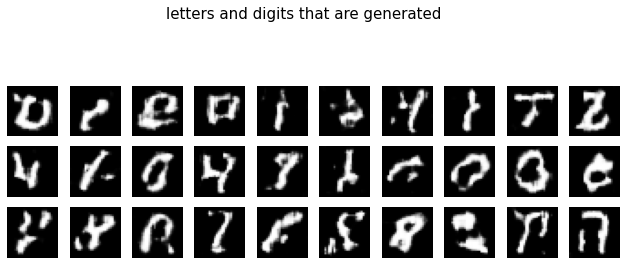

current epouch is:  11
discriminator loss currently is :  0.44669970870018005
generator loss currently is:  1.3285002708435059
--------------------------------------------------------------------------------
current epouch is:  12
discriminator loss currently is :  0.47120070457458496
generator loss currently is:  1.519895076751709
--------------------------------------------------------------------------------
current epouch is:  13
discriminator loss currently is :  0.46207481622695923
generator loss currently is:  1.4531350135803223
--------------------------------------------------------------------------------
current epouch is:  14
discriminator loss currently is :  0.4917829632759094
generator loss currently is:  1.9403823614120483
--------------------------------------------------------------------------------
current epouch is:  15
discriminator loss currently is :  0.46186625957489014
generator loss currently is:  1.5367279052734375
-------------------------------------------

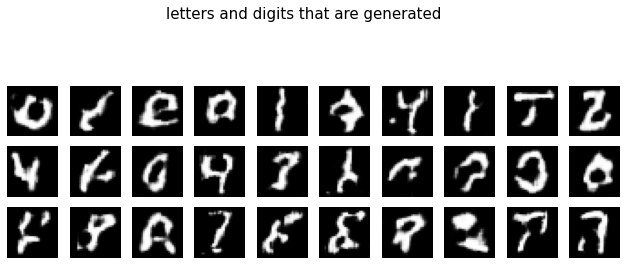

current epouch is:  16
discriminator loss currently is :  0.480547159910202
generator loss currently is:  1.4538910388946533
--------------------------------------------------------------------------------
current epouch is:  17
discriminator loss currently is :  0.4803720712661743
generator loss currently is:  1.321427822113037
--------------------------------------------------------------------------------
current epouch is:  18
discriminator loss currently is :  0.46865108609199524
generator loss currently is:  1.6285985708236694
--------------------------------------------------------------------------------
current epouch is:  19
discriminator loss currently is :  0.4692952036857605
generator loss currently is:  1.6060914993286133
--------------------------------------------------------------------------------
current epouch is:  20
discriminator loss currently is :  0.4646316170692444
generator loss currently is:  1.2357603311538696
-----------------------------------------------

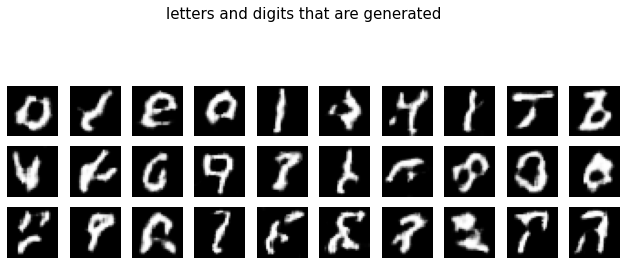

current epouch is:  21
discriminator loss currently is :  0.4812469184398651
generator loss currently is:  1.8456007242202759
--------------------------------------------------------------------------------
current epouch is:  22
discriminator loss currently is :  0.4778915047645569
generator loss currently is:  1.5842180252075195
--------------------------------------------------------------------------------
current epouch is:  23
discriminator loss currently is :  0.4827691912651062
generator loss currently is:  2.0841846466064453
--------------------------------------------------------------------------------
current epouch is:  24
discriminator loss currently is :  0.4644620716571808
generator loss currently is:  1.346966028213501
--------------------------------------------------------------------------------
current epouch is:  25
discriminator loss currently is :  0.4539957642555237
generator loss currently is:  1.4378150701522827
-----------------------------------------------

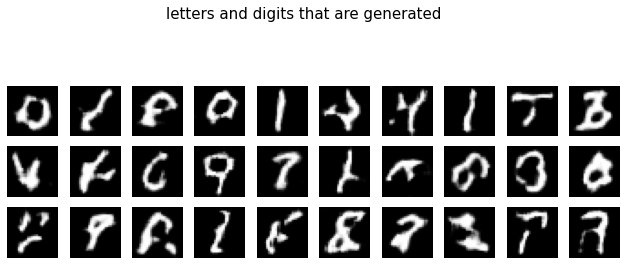

current epouch is:  26
discriminator loss currently is :  0.4553220868110657
generator loss currently is:  1.6018693447113037
--------------------------------------------------------------------------------
current epouch is:  27
discriminator loss currently is :  0.4597123861312866
generator loss currently is:  1.5881059169769287
--------------------------------------------------------------------------------
current epouch is:  28
discriminator loss currently is :  0.45421063899993896
generator loss currently is:  1.3407247066497803
--------------------------------------------------------------------------------
current epouch is:  29
discriminator loss currently is :  0.5182658433914185
generator loss currently is:  1.197728157043457
--------------------------------------------------------------------------------
current epouch is:  30
discriminator loss currently is :  0.4540213942527771
generator loss currently is:  1.69398832321167
------------------------------------------------

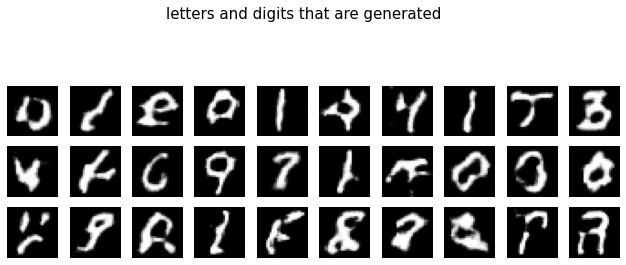

current epouch is:  31
discriminator loss currently is :  0.4555715322494507
generator loss currently is:  1.6097456216812134
--------------------------------------------------------------------------------
current epouch is:  32
discriminator loss currently is :  0.4880702495574951
generator loss currently is:  2.1307272911071777
--------------------------------------------------------------------------------
current epouch is:  33
discriminator loss currently is :  0.4553249478340149
generator loss currently is:  1.2500269412994385
--------------------------------------------------------------------------------
current epouch is:  34
discriminator loss currently is :  0.5191637277603149
generator loss currently is:  2.4286670684814453
--------------------------------------------------------------------------------
current epouch is:  35
discriminator loss currently is :  0.4786931276321411
generator loss currently is:  2.016160249710083
-----------------------------------------------

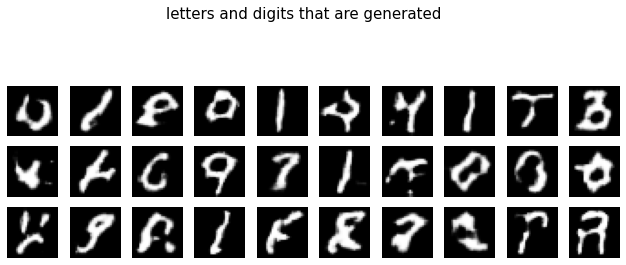

current epouch is:  36
discriminator loss currently is :  0.43341171741485596
generator loss currently is:  1.6858789920806885
--------------------------------------------------------------------------------
current epouch is:  37
discriminator loss currently is :  0.44775405526161194
generator loss currently is:  1.8304502964019775
--------------------------------------------------------------------------------
current epouch is:  38
discriminator loss currently is :  0.42855527997016907
generator loss currently is:  1.4835388660430908
--------------------------------------------------------------------------------
current epouch is:  39
discriminator loss currently is :  0.4589403569698334
generator loss currently is:  1.390804409980774
--------------------------------------------------------------------------------
current epouch is:  40
discriminator loss currently is :  0.5303528904914856
generator loss currently is:  2.331333637237549
---------------------------------------------

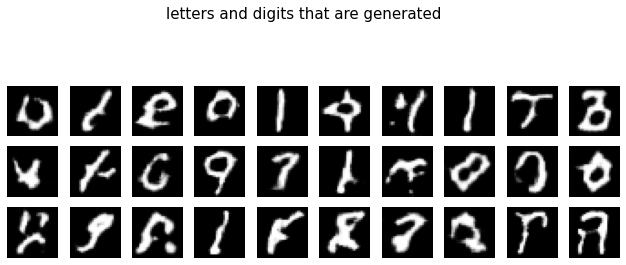

current epouch is:  41
discriminator loss currently is :  0.4334661066532135
generator loss currently is:  1.5090086460113525
--------------------------------------------------------------------------------
current epouch is:  42
discriminator loss currently is :  0.5053170323371887
generator loss currently is:  2.332282543182373
--------------------------------------------------------------------------------
current epouch is:  43
discriminator loss currently is :  0.4439956545829773
generator loss currently is:  2.3443408012390137
--------------------------------------------------------------------------------
current epouch is:  44
discriminator loss currently is :  0.4708437919616699
generator loss currently is:  1.5240252017974854
--------------------------------------------------------------------------------
current epouch is:  45
discriminator loss currently is :  0.4661571681499481
generator loss currently is:  1.5829510688781738
-----------------------------------------------

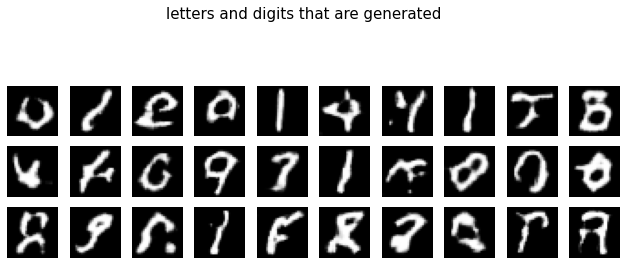

current epouch is:  46
discriminator loss currently is :  0.44557708501815796
generator loss currently is:  2.2052085399627686
--------------------------------------------------------------------------------
current epouch is:  47
discriminator loss currently is :  0.43825334310531616
generator loss currently is:  1.3713147640228271
--------------------------------------------------------------------------------
current epouch is:  48
discriminator loss currently is :  0.43602773547172546
generator loss currently is:  1.6368365287780762
--------------------------------------------------------------------------------
current epouch is:  49
discriminator loss currently is :  0.550758421421051
generator loss currently is:  1.162339210510254
--------------------------------------------------------------------------------
current epouch is:  50
discriminator loss currently is :  0.4123474955558777
generator loss currently is:  1.8208853006362915
---------------------------------------------

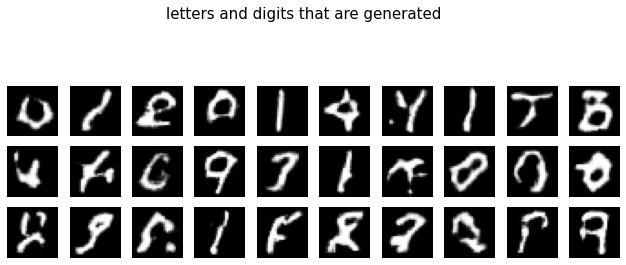

current epouch is:  51
discriminator loss currently is :  0.44226545095443726
generator loss currently is:  1.441138744354248
--------------------------------------------------------------------------------
current epouch is:  52
discriminator loss currently is :  0.44220227003097534
generator loss currently is:  1.4258617162704468
--------------------------------------------------------------------------------
current epouch is:  53
discriminator loss currently is :  0.5301492214202881
generator loss currently is:  2.1379294395446777
--------------------------------------------------------------------------------
current epouch is:  54
discriminator loss currently is :  0.44491928815841675
generator loss currently is:  2.383251428604126
--------------------------------------------------------------------------------
current epouch is:  55
discriminator loss currently is :  0.49071094393730164
generator loss currently is:  2.2758219242095947
--------------------------------------------

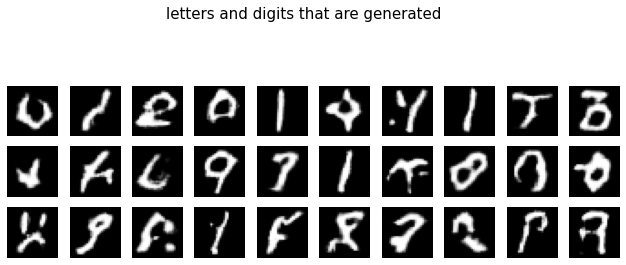

current epouch is:  56
discriminator loss currently is :  0.4205966889858246
generator loss currently is:  1.6982178688049316
--------------------------------------------------------------------------------
current epouch is:  57
discriminator loss currently is :  0.4236626923084259
generator loss currently is:  1.6596510410308838
--------------------------------------------------------------------------------
current epouch is:  58
discriminator loss currently is :  0.4780477285385132
generator loss currently is:  0.97871994972229
--------------------------------------------------------------------------------
current epouch is:  59
discriminator loss currently is :  0.49712249636650085
generator loss currently is:  1.3871091604232788
--------------------------------------------------------------------------------
current epouch is:  60
discriminator loss currently is :  0.42905300855636597
generator loss currently is:  1.9033808708190918
----------------------------------------------

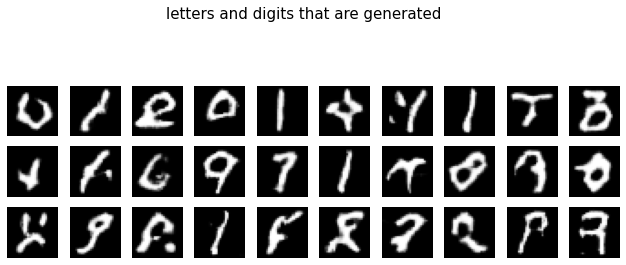

current epouch is:  61
discriminator loss currently is :  0.42730534076690674
generator loss currently is:  2.0094637870788574
--------------------------------------------------------------------------------
current epouch is:  62
discriminator loss currently is :  0.43349698185920715
generator loss currently is:  1.7884584665298462
--------------------------------------------------------------------------------
current epouch is:  63
discriminator loss currently is :  0.4653712511062622
generator loss currently is:  1.5945992469787598
--------------------------------------------------------------------------------
current epouch is:  64
discriminator loss currently is :  0.4213181138038635
generator loss currently is:  1.8298842906951904
--------------------------------------------------------------------------------
current epouch is:  65
discriminator loss currently is :  0.4476679563522339
generator loss currently is:  1.3014872074127197
--------------------------------------------

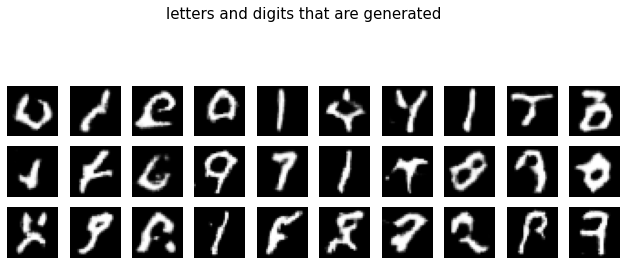

current epouch is:  66
discriminator loss currently is :  0.4543808102607727
generator loss currently is:  2.3442938327789307
--------------------------------------------------------------------------------
current epouch is:  67
discriminator loss currently is :  0.41137760877609253
generator loss currently is:  1.87917959690094
--------------------------------------------------------------------------------
current epouch is:  68
discriminator loss currently is :  0.47467300295829773
generator loss currently is:  2.860765218734741
--------------------------------------------------------------------------------
current epouch is:  69
discriminator loss currently is :  0.4400884509086609
generator loss currently is:  1.4536070823669434
--------------------------------------------------------------------------------
current epouch is:  70
discriminator loss currently is :  0.40948212146759033
generator loss currently is:  1.559577226638794
-----------------------------------------------

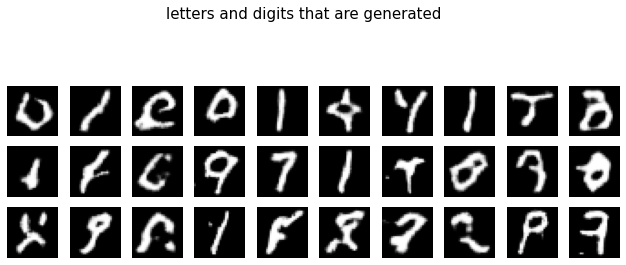

current epouch is:  71
discriminator loss currently is :  0.4147466719150543
generator loss currently is:  2.003591775894165
--------------------------------------------------------------------------------
current epouch is:  72
discriminator loss currently is :  0.4223126769065857
generator loss currently is:  2.0409622192382812
--------------------------------------------------------------------------------
current epouch is:  73
discriminator loss currently is :  0.4649471044540405
generator loss currently is:  2.589092254638672
--------------------------------------------------------------------------------
current epouch is:  74
discriminator loss currently is :  0.4578121304512024
generator loss currently is:  2.221083402633667
--------------------------------------------------------------------------------
current epouch is:  75
discriminator loss currently is :  0.5020850300788879
generator loss currently is:  1.2089967727661133
-------------------------------------------------

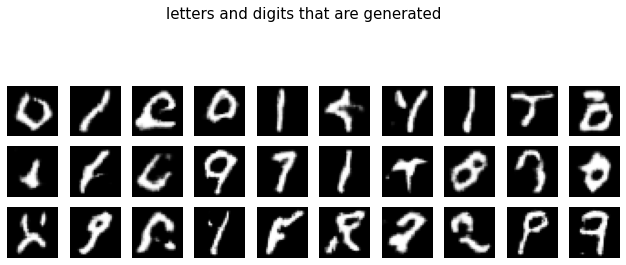

current epouch is:  76
discriminator loss currently is :  0.4465115964412689
generator loss currently is:  1.454525113105774
--------------------------------------------------------------------------------
current epouch is:  77
discriminator loss currently is :  0.43660902976989746
generator loss currently is:  1.3848307132720947
--------------------------------------------------------------------------------
current epouch is:  78
discriminator loss currently is :  0.4096902310848236
generator loss currently is:  1.897383213043213
--------------------------------------------------------------------------------
current epouch is:  79
discriminator loss currently is :  0.418814092874527
generator loss currently is:  2.187485933303833
--------------------------------------------------------------------------------
current epouch is:  80
discriminator loss currently is :  0.4188234210014343
generator loss currently is:  2.0787813663482666
-------------------------------------------------

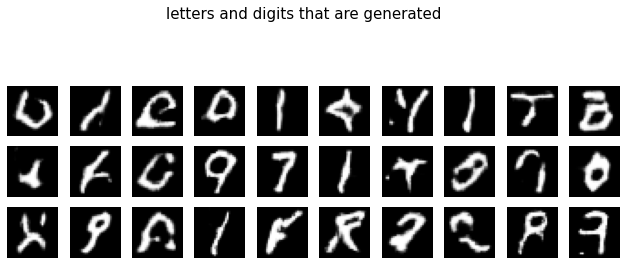

current epouch is:  81
discriminator loss currently is :  0.431180864572525
generator loss currently is:  2.0394604206085205
--------------------------------------------------------------------------------
current epouch is:  82
discriminator loss currently is :  0.4262763261795044
generator loss currently is:  1.5122922658920288
--------------------------------------------------------------------------------
current epouch is:  83
discriminator loss currently is :  0.4076371192932129
generator loss currently is:  2.25321364402771
--------------------------------------------------------------------------------
current epouch is:  84
discriminator loss currently is :  0.40901684761047363
generator loss currently is:  1.9069381952285767
--------------------------------------------------------------------------------
current epouch is:  85
discriminator loss currently is :  0.48390933871269226
generator loss currently is:  0.8570336699485779
-----------------------------------------------

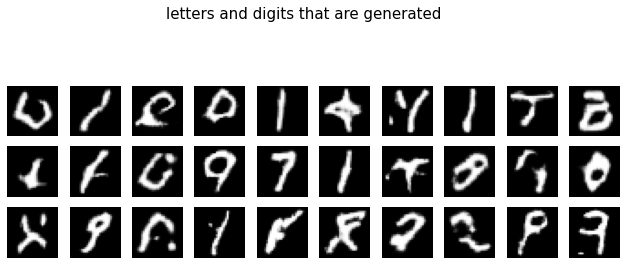

current epouch is:  86
discriminator loss currently is :  0.4156149625778198
generator loss currently is:  1.7320390939712524
--------------------------------------------------------------------------------
current epouch is:  87
discriminator loss currently is :  0.4364073872566223
generator loss currently is:  2.6227495670318604
--------------------------------------------------------------------------------
current epouch is:  88
discriminator loss currently is :  0.39289551973342896
generator loss currently is:  2.357283592224121
--------------------------------------------------------------------------------
current epouch is:  89
discriminator loss currently is :  0.4338085353374481
generator loss currently is:  1.5012497901916504
--------------------------------------------------------------------------------
current epouch is:  90
discriminator loss currently is :  0.4055075943470001
generator loss currently is:  1.8937242031097412
----------------------------------------------

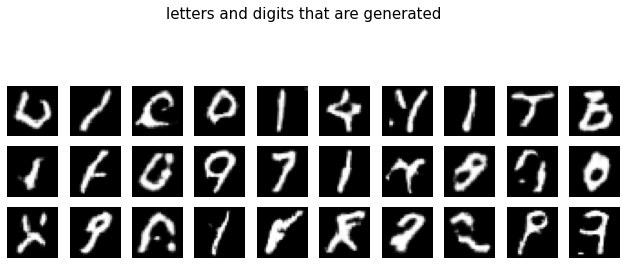

current epouch is:  91
discriminator loss currently is :  0.4090343713760376
generator loss currently is:  2.245391845703125
--------------------------------------------------------------------------------
current epouch is:  92
discriminator loss currently is :  0.4052538275718689
generator loss currently is:  2.1923136711120605
--------------------------------------------------------------------------------
current epouch is:  93
discriminator loss currently is :  0.4053163230419159
generator loss currently is:  1.950303554534912
--------------------------------------------------------------------------------
current epouch is:  94
discriminator loss currently is :  0.4131562113761902
generator loss currently is:  1.8150537014007568
--------------------------------------------------------------------------------
current epouch is:  95
discriminator loss currently is :  0.40359658002853394
generator loss currently is:  1.7453947067260742
-----------------------------------------------

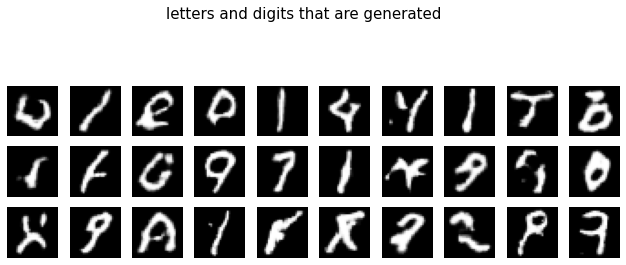

current epouch is:  96
discriminator loss currently is :  0.45280230045318604
generator loss currently is:  1.5855164527893066
--------------------------------------------------------------------------------
current epouch is:  97
discriminator loss currently is :  0.4119734764099121
generator loss currently is:  2.401174545288086
--------------------------------------------------------------------------------
current epouch is:  98
discriminator loss currently is :  0.4119827449321747
generator loss currently is:  2.0149221420288086
--------------------------------------------------------------------------------
current epouch is:  99
discriminator loss currently is :  0.3937963545322418
generator loss currently is:  2.314673900604248
--------------------------------------------------------------------------------
current epouch is:  100
discriminator loss currently is :  0.40629327297210693
generator loss currently is:  1.8964142799377441
---------------------------------------------

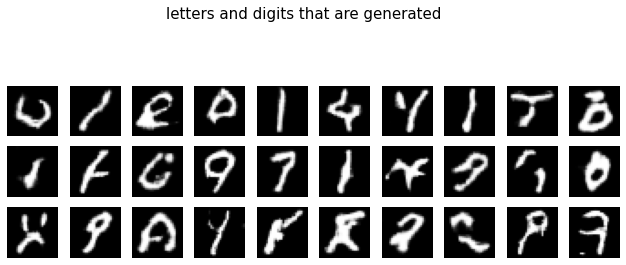

current epouch is:  101
discriminator loss currently is :  0.4617956578731537
generator loss currently is:  2.7357990741729736
--------------------------------------------------------------------------------
current epouch is:  102
discriminator loss currently is :  0.39241668581962585
generator loss currently is:  2.016345977783203
--------------------------------------------------------------------------------
current epouch is:  103
discriminator loss currently is :  0.44128116965293884
generator loss currently is:  1.1967405080795288
--------------------------------------------------------------------------------
current epouch is:  104
discriminator loss currently is :  0.4278395175933838
generator loss currently is:  1.7408583164215088
--------------------------------------------------------------------------------
current epouch is:  105
discriminator loss currently is :  0.4064248204231262
generator loss currently is:  1.8229659795761108
----------------------------------------

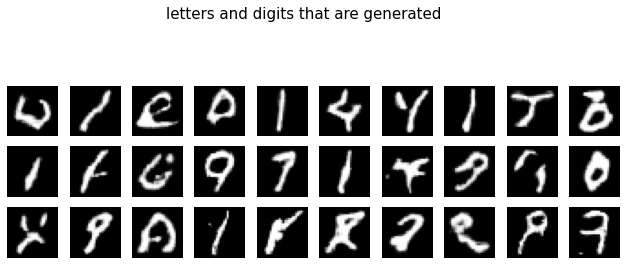

current epouch is:  106
discriminator loss currently is :  0.42897847294807434
generator loss currently is:  1.783060073852539
--------------------------------------------------------------------------------
current epouch is:  107
discriminator loss currently is :  0.41162413358688354
generator loss currently is:  2.4345712661743164
--------------------------------------------------------------------------------
current epouch is:  108
discriminator loss currently is :  0.434502512216568
generator loss currently is:  1.3805017471313477
--------------------------------------------------------------------------------
current epouch is:  109
discriminator loss currently is :  0.4013242721557617
generator loss currently is:  2.0348687171936035
--------------------------------------------------------------------------------
current epouch is:  110
discriminator loss currently is :  0.40357694029808044
generator loss currently is:  1.8415288925170898
----------------------------------------

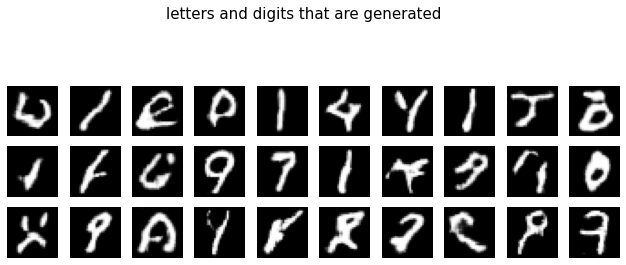

current epouch is:  111
discriminator loss currently is :  0.4126525819301605
generator loss currently is:  2.4025278091430664
--------------------------------------------------------------------------------
current epouch is:  112
discriminator loss currently is :  0.4278406798839569
generator loss currently is:  1.9277305603027344
--------------------------------------------------------------------------------
current epouch is:  113
discriminator loss currently is :  0.3988656997680664
generator loss currently is:  2.0250484943389893
--------------------------------------------------------------------------------
current epouch is:  114
discriminator loss currently is :  0.4162428677082062
generator loss currently is:  2.4934191703796387
--------------------------------------------------------------------------------
current epouch is:  115
discriminator loss currently is :  0.40991175174713135
generator loss currently is:  1.672478437423706
-----------------------------------------

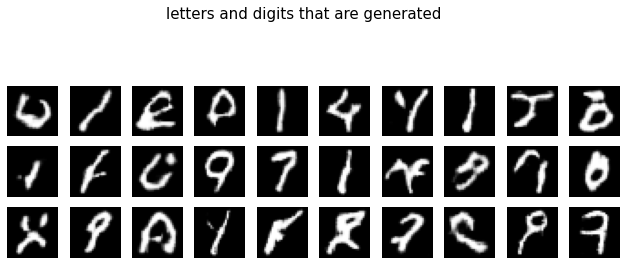

current epouch is:  116
discriminator loss currently is :  0.47260841727256775
generator loss currently is:  2.7051877975463867
--------------------------------------------------------------------------------
current epouch is:  117
discriminator loss currently is :  0.41241127252578735
generator loss currently is:  2.166431188583374
--------------------------------------------------------------------------------
current epouch is:  118
discriminator loss currently is :  0.40399181842803955
generator loss currently is:  1.830592155456543
--------------------------------------------------------------------------------
current epouch is:  119
discriminator loss currently is :  0.3982170820236206
generator loss currently is:  2.1065948009490967
--------------------------------------------------------------------------------
current epouch is:  120
discriminator loss currently is :  0.41181692481040955
generator loss currently is:  2.0933244228363037
---------------------------------------

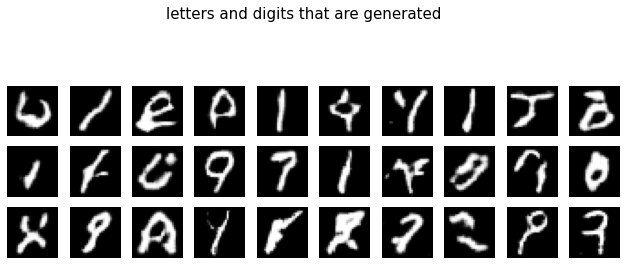

current epouch is:  121
discriminator loss currently is :  0.4159482419490814
generator loss currently is:  1.6961467266082764
--------------------------------------------------------------------------------
current epouch is:  122
discriminator loss currently is :  0.4353410601615906
generator loss currently is:  2.9152398109436035
--------------------------------------------------------------------------------
current epouch is:  123
discriminator loss currently is :  0.40227019786834717
generator loss currently is:  2.107287883758545
--------------------------------------------------------------------------------
current epouch is:  124
discriminator loss currently is :  0.4442293047904968
generator loss currently is:  2.9241275787353516
--------------------------------------------------------------------------------
current epouch is:  125
discriminator loss currently is :  0.4007725119590759
generator loss currently is:  1.8846642971038818
-----------------------------------------

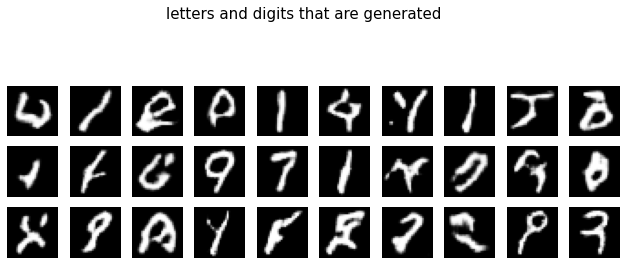

current epouch is:  126
discriminator loss currently is :  0.42810821533203125
generator loss currently is:  2.322451591491699
--------------------------------------------------------------------------------
current epouch is:  127
discriminator loss currently is :  0.4096747636795044
generator loss currently is:  1.8434745073318481
--------------------------------------------------------------------------------
current epouch is:  128
discriminator loss currently is :  0.42147955298423767
generator loss currently is:  1.7759649753570557
--------------------------------------------------------------------------------
current epouch is:  129
discriminator loss currently is :  0.41157352924346924
generator loss currently is:  1.506234884262085
--------------------------------------------------------------------------------
current epouch is:  130
discriminator loss currently is :  0.4045277237892151
generator loss currently is:  1.950148344039917
-----------------------------------------

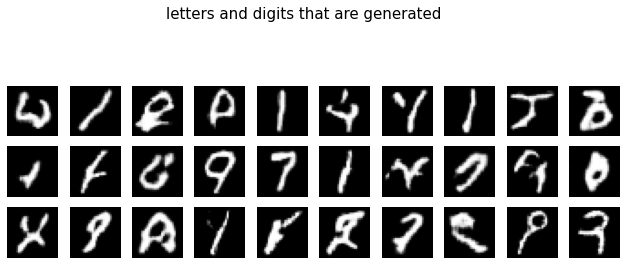

current epouch is:  131
discriminator loss currently is :  0.3949093520641327
generator loss currently is:  2.104351758956909
--------------------------------------------------------------------------------
current epouch is:  132
discriminator loss currently is :  0.42639827728271484
generator loss currently is:  2.3956446647644043
--------------------------------------------------------------------------------
current epouch is:  133
discriminator loss currently is :  0.4015316963195801
generator loss currently is:  1.997295618057251
--------------------------------------------------------------------------------
current epouch is:  134
discriminator loss currently is :  0.38650786876678467
generator loss currently is:  1.8471343517303467
--------------------------------------------------------------------------------
current epouch is:  135
discriminator loss currently is :  0.3999628722667694
generator loss currently is:  1.8140712976455688
-----------------------------------------

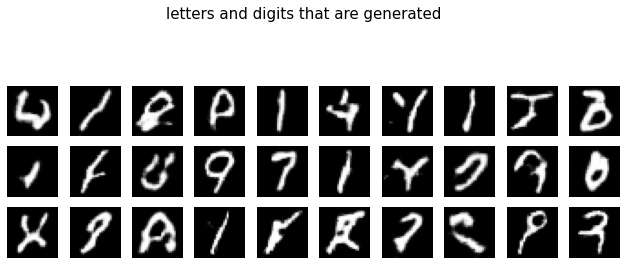

current epouch is:  136
discriminator loss currently is :  0.405417263507843
generator loss currently is:  1.5230014324188232
--------------------------------------------------------------------------------
current epouch is:  137
discriminator loss currently is :  0.4109562337398529
generator loss currently is:  1.6159478425979614
--------------------------------------------------------------------------------
current epouch is:  138
discriminator loss currently is :  0.4199107885360718
generator loss currently is:  1.83328115940094
--------------------------------------------------------------------------------
current epouch is:  139
discriminator loss currently is :  0.39801931381225586
generator loss currently is:  1.9651522636413574
--------------------------------------------------------------------------------
current epouch is:  140
discriminator loss currently is :  0.39508920907974243
generator loss currently is:  2.106224536895752
-------------------------------------------

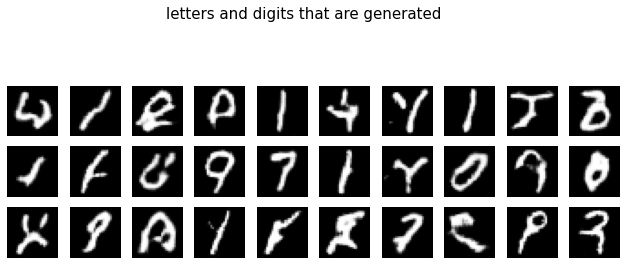

current epouch is:  141
discriminator loss currently is :  0.42561179399490356
generator loss currently is:  2.263762950897217
--------------------------------------------------------------------------------
current epouch is:  142
discriminator loss currently is :  0.39882415533065796
generator loss currently is:  2.376188278198242
--------------------------------------------------------------------------------
current epouch is:  143
discriminator loss currently is :  0.407794713973999
generator loss currently is:  1.987187147140503
--------------------------------------------------------------------------------
current epouch is:  144
discriminator loss currently is :  0.3953089118003845
generator loss currently is:  1.7685763835906982
--------------------------------------------------------------------------------
current epouch is:  145
discriminator loss currently is :  0.40648597478866577
generator loss currently is:  2.2198164463043213
------------------------------------------

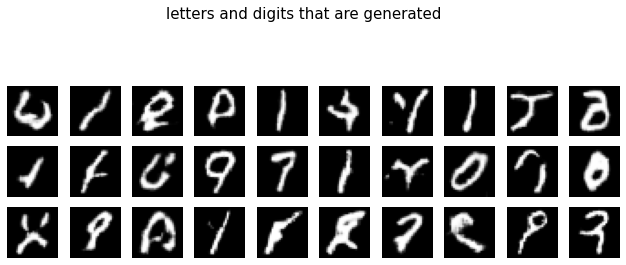

current epouch is:  146
discriminator loss currently is :  0.4107228219509125
generator loss currently is:  1.6500792503356934
--------------------------------------------------------------------------------
current epouch is:  147
discriminator loss currently is :  0.39566290378570557
generator loss currently is:  2.2601442337036133
--------------------------------------------------------------------------------
current epouch is:  148
discriminator loss currently is :  0.4198186993598938
generator loss currently is:  2.529555559158325
--------------------------------------------------------------------------------
current epouch is:  149
discriminator loss currently is :  0.39699587225914
generator loss currently is:  1.836374282836914
--------------------------------------------------------------------------------
current epouch is:  150
discriminator loss currently is :  0.39033767580986023
generator loss currently is:  1.8861027956008911
-------------------------------------------

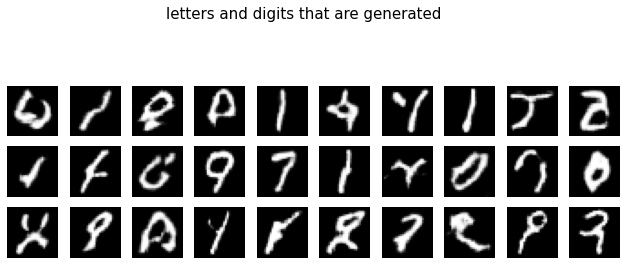

current epouch is:  151
discriminator loss currently is :  0.39724355936050415
generator loss currently is:  2.4938859939575195
--------------------------------------------------------------------------------
current epouch is:  152
discriminator loss currently is :  0.4015834331512451
generator loss currently is:  2.2562811374664307
--------------------------------------------------------------------------------
current epouch is:  153
discriminator loss currently is :  0.3868151307106018
generator loss currently is:  2.1183645725250244
--------------------------------------------------------------------------------
current epouch is:  154
discriminator loss currently is :  0.4059350788593292
generator loss currently is:  1.792420506477356
--------------------------------------------------------------------------------
current epouch is:  155
discriminator loss currently is :  0.39530107378959656
generator loss currently is:  1.7961305379867554
----------------------------------------

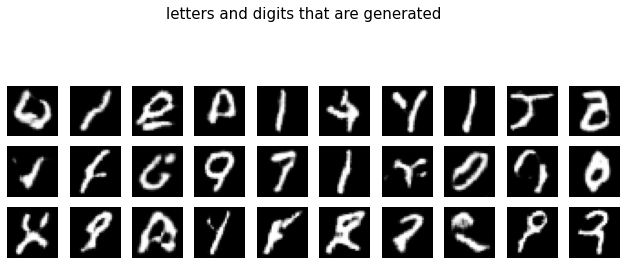

current epouch is:  156
discriminator loss currently is :  0.39806726574897766
generator loss currently is:  2.012674570083618
--------------------------------------------------------------------------------
current epouch is:  157
discriminator loss currently is :  0.39198359847068787
generator loss currently is:  1.8961620330810547
--------------------------------------------------------------------------------
current epouch is:  158
discriminator loss currently is :  0.42347967624664307
generator loss currently is:  1.7432172298431396
--------------------------------------------------------------------------------
current epouch is:  159
discriminator loss currently is :  0.4000173807144165
generator loss currently is:  1.7296473979949951
--------------------------------------------------------------------------------
current epouch is:  160
discriminator loss currently is :  0.44627201557159424
generator loss currently is:  1.1083160638809204
--------------------------------------

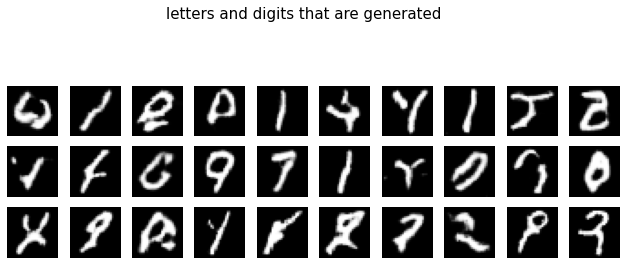

current epouch is:  161
discriminator loss currently is :  0.39409154653549194
generator loss currently is:  1.6977936029434204
--------------------------------------------------------------------------------
current epouch is:  162
discriminator loss currently is :  0.39785072207450867
generator loss currently is:  1.861310362815857
--------------------------------------------------------------------------------
current epouch is:  163
discriminator loss currently is :  0.40893682837486267
generator loss currently is:  2.5965893268585205
--------------------------------------------------------------------------------
current epouch is:  164
discriminator loss currently is :  0.3980591893196106
generator loss currently is:  2.1302733421325684
--------------------------------------------------------------------------------
current epouch is:  165
discriminator loss currently is :  0.40089118480682373
generator loss currently is:  2.457815647125244
---------------------------------------

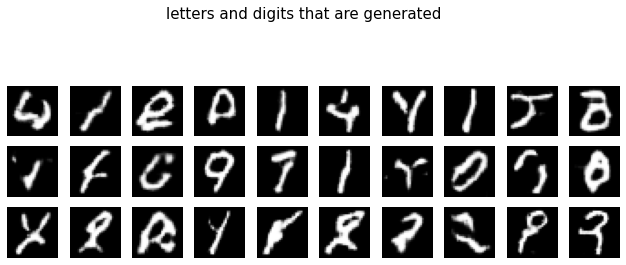

current epouch is:  166
discriminator loss currently is :  0.43365398049354553
generator loss currently is:  2.674529790878296
--------------------------------------------------------------------------------
current epouch is:  167
discriminator loss currently is :  0.449567973613739
generator loss currently is:  1.139899492263794
--------------------------------------------------------------------------------
current epouch is:  168
discriminator loss currently is :  0.39194390177726746
generator loss currently is:  2.0231871604919434
--------------------------------------------------------------------------------
current epouch is:  169
discriminator loss currently is :  0.4145384430885315
generator loss currently is:  2.4286842346191406
--------------------------------------------------------------------------------
current epouch is:  170
discriminator loss currently is :  0.392927348613739
generator loss currently is:  2.021346092224121
--------------------------------------------

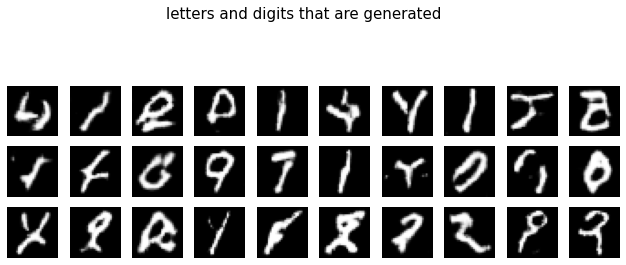

current epouch is:  171
discriminator loss currently is :  0.3913550078868866
generator loss currently is:  2.1432676315307617
--------------------------------------------------------------------------------
current epouch is:  172
discriminator loss currently is :  0.40139079093933105
generator loss currently is:  1.9568036794662476
--------------------------------------------------------------------------------
current epouch is:  173
discriminator loss currently is :  0.43608492612838745
generator loss currently is:  3.098473072052002
--------------------------------------------------------------------------------
current epouch is:  174
discriminator loss currently is :  0.386891633272171
generator loss currently is:  2.050461530685425
--------------------------------------------------------------------------------
current epouch is:  175
discriminator loss currently is :  0.38372230529785156
generator loss currently is:  1.9634361267089844
-----------------------------------------

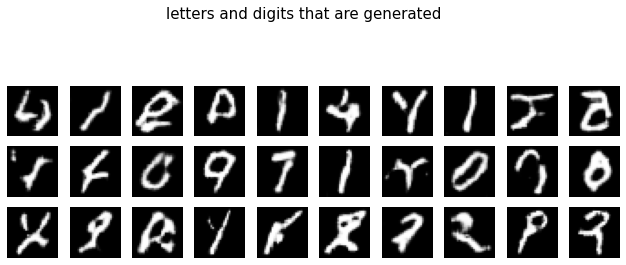

current epouch is:  176
discriminator loss currently is :  0.43531620502471924
generator loss currently is:  1.6024484634399414
--------------------------------------------------------------------------------
current epouch is:  177
discriminator loss currently is :  0.3860557973384857
generator loss currently is:  2.2787694931030273
--------------------------------------------------------------------------------


KeyboardInterrupt: ignored

In [23]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        inputgenerator = np.random.normal(0, 1, size=(batch_size, ND))
        fakedataG = G.predict(inputgenerator)
        realdataG = trainingx[np.random.randint(0, trainingx.shape[0], size=batch_size)]
        realdataG = realdataG.reshape((batch_size, 28, 28, 1))
        inputdiscriminator= np.concatenate((realdataG , fakedataG))
        labeldiscriminator = np.zeros(2*batch_size)
        labeldiscriminator[:batch_size] = 0.9
        labeldiscriminator[batch_size:] = 0.1
        lossdiscriminator= D.train_on_batch(inputdiscriminator, labeldiscriminator)
        labelgenerator= np.ones(batch_size)
        lossgenerator = DCGAN.train_on_batch(inputgenerator, labelgenerator)

    print("current epouch is: ", epoch)
    print("discriminator loss currently is : ", lossdiscriminator)
    print("generator loss currently is: ", lossgenerator)
    print("-"*80)
    
    if epoch % 5 == 0:
        show_results("letters and digits that are generated", epoch)